# Modeling Temporary Impact $g_t(x)$


Chaitanya Agarwal

This notebook contains experients with the generated slippage data to model the temporary impact function $g_t(x)$.

## Index:
0. Setup and Config
1. Load simulated slippage data
2. Clean data
3. Exploratory Data Analysis(EDA)
4. Model Fitting
   


## Setup

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Loading Slippage Data

In [100]:
impacts_csv = "../data/processed/impacts_20250731_062933.csv"


df = pd.read_csv(impacts_csv, parse_dates=['ts'])
df['ts'] = pd.to_datetime(df['ts'], utc=True, format="mixed")
print("Loaded data with shape:", df.shape)

df.tail()

Loaded data with shape: (51309234, 5)


,ticker,ts,size,slippage,spread
51309229,SOUN,2025-05-02 19:59:59.991539809+00:00,232,0.005690,0.01
51309230,SOUN,2025-05-02 19:59:59.991539809+00:00,499,0.010671,0.01
51309231,SOUN,2025-05-02 19:59:59.991539809+00:00,1077,0.012994,0.01
51309232,SOUN,2025-05-02 19:59:59.991539809+00:00,2320,0.014069,0.01
51309233,SOUN,2025-05-02 19:59:59.991539809+00:00,4999,0.014568,0.01


## Data Cleaning

In [101]:
# drop zero/negative slippage
df = df[df['slippage'] > 0]

# drop rows with any NaNs in key columns
df.dropna(subset=['ticker','size','slippage','spread'], inplace=True)


print("Tickers:", df['ticker'].unique())

# row counts per ticker
print(df['ticker'].value_counts().rename_axis('ticker').reset_index(name='count'))

Tickers: ['CRWV' 'FROG' 'SOUN']
  ticker     count
0   SOUN  38523596
1   CRWV   9813640
2   FROG   2971998


## Exploratory Data Analysis

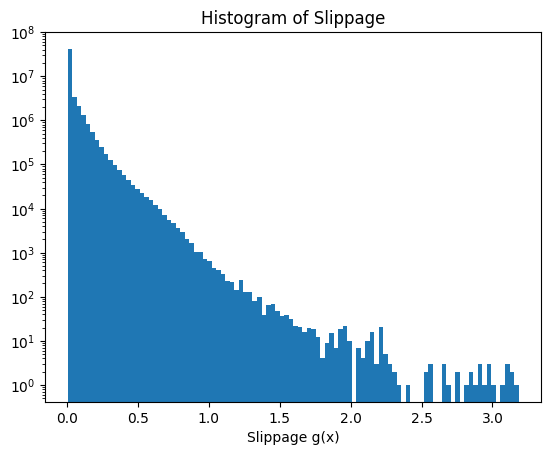

In [102]:
plt.hist(df['slippage'], bins=100, log=True)
plt.xlabel('Slippage g(x)')
plt.title('Histogram of Slippage')
plt.show()

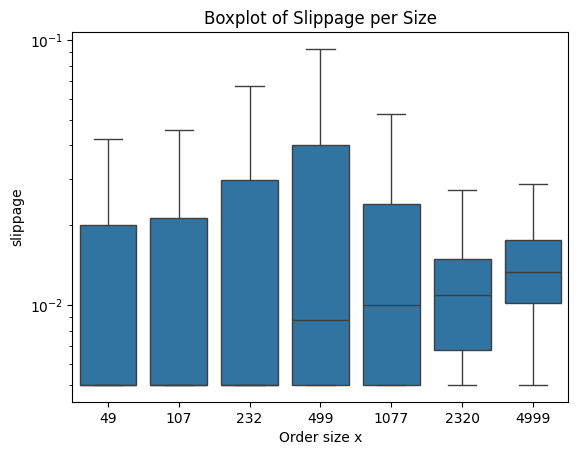

In [103]:
sns.boxplot(x='size', y='slippage', data=df, showfliers=False)
plt.yscale('log')
plt.xlabel('Order size x')
plt.title('Boxplot of Slippage per Size')
plt.show()

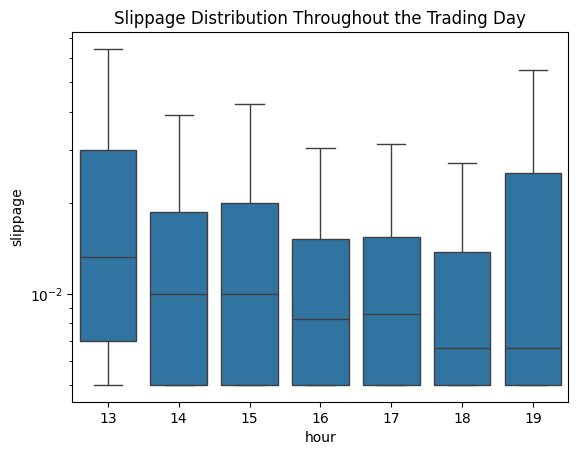

In [104]:
df['hour'] = df['ts'].dt.hour
sns.boxplot(x='hour', y='slippage', data=df, showfliers=False)
plt.yscale('log')
plt.title('Slippage Distribution Throughout the Trading Day')
plt.show()

### Raw Slippage vs. Order Size

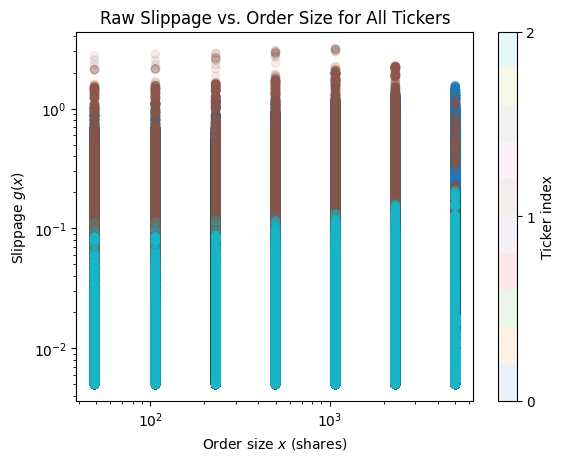

In [105]:
plt.scatter(df['size'], df['slippage'], c=pd.Categorical(df['ticker']).codes,
            alpha=0.1, cmap='tab10')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Order size $x$ (shares)')
plt.ylabel('Slippage $g(x)$')
plt.title('Raw Slippage vs. Order Size for All Tickers')
plt.colorbar(ticks=[0,1,2], label='Ticker index')
plt.show()

### Median and Mean Slippage per Ticker

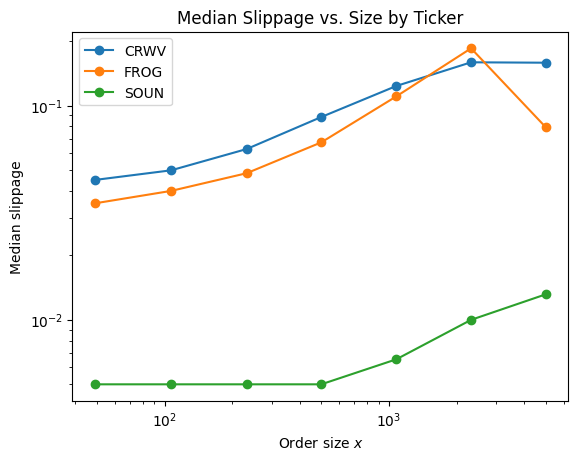

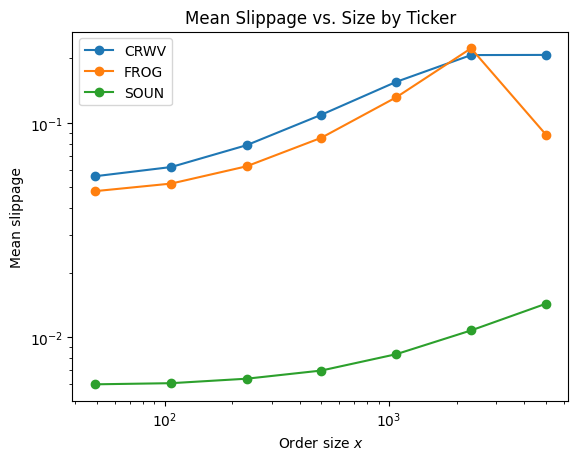

In [106]:
agg = df.groupby(['ticker','size'])['slippage'].agg(['median','mean']).reset_index()

for stat in ['median','mean']:
    plt.figure()
    for ticker in agg['ticker'].unique():
        sub = agg[agg['ticker']==ticker]
        plt.plot(sub['size'], sub[stat], 'o-', label=f"{ticker}")
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Order size $x$'); plt.ylabel(f'{stat.title()} slippage')
    plt.title(f'{stat.title()} Slippage vs. Size by Ticker')
    plt.legend(); plt.show()

## Fitting Models

1. Linear: $g(x)=\beta\,x$
2. Power-law: $g(x)=\alpha\,x^{\gamma}$
3. Almgren-Chriss model

In [107]:
#  median slippage by size
#  example of what it should look like:
#  ticker     size     median_slip
#    CRWV      10      0.001
#    CRWV      50      0.003  
median_slippage = df.groupby(['ticker','size'])['slippage'] \
        .median() \
        .reset_index(name='median_slip')

### Linear $g(x)=\beta x$

In [108]:
linear_results = []
for ticker, sub in median_slippage.groupby('ticker'):
    X = sub[['size']].values       # (N,1)
    y = sub['median_slip'].values  # (N,)

    
    model = LinearRegression(fit_intercept=False).fit(X, y)
    beta = model.coef_[0]
    y_hat = model.predict(X)
    rmse = mean_squared_error(y, y_hat)
    r2 = r2_score(y, y_hat)

    
    linear_results.append({
        'ticker': ticker,
        'β (beta)': beta,
        'RMSE': rmse,
        'R²': r2
    })

linear_df = pd.DataFrame(linear_results).set_index('ticker')
print(linear_df)

        β (beta)      RMSE        R²
ticker                              
CRWV    0.000043  0.003407 -0.638210
FROG    0.000031  0.004483 -0.870087
SOUN    0.000003  0.000014 -0.568761


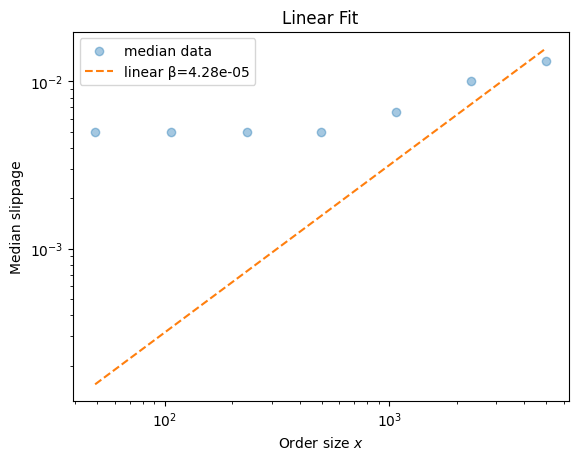

In [109]:
X, y = sub[['size']].values, sub['median_slip'].values
y_hat = LinearRegression(fit_intercept=False).fit(X, y).predict(X)

plt.figure()
plt.scatter(X, y, alpha=0.4, label='median data')
plt.plot(X, y_hat, 'C1--', label=f'linear β={linear_df.loc[tkr,"β (beta)"]:.2e}')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Order size $x$'); plt.ylabel('Median slippage')
plt.title(f'Linear Fit')
plt.legend(); 
plt.show()

### Power-law $g(x)=\alpha\,x^{\gamma}$

In [110]:
powerlaw_results = []
for ticker, sub in median_slippage.groupby('ticker'):
    x = sub['size'].values
    y = sub['median_slip'].values

    
    logx, logy = np.log(x), np.log(y)
    gamma, log_alpha = np.polyfit(logx, logy, 1)
    alpha = np.exp(log_alpha)
    y_hat = alpha * x**gamma
    rmse = mean_squared_error(y, y_hat)
    r2 = r2_score(logy, np.log(y_hat))

    
    powerlaw_results.append({
        'ticker': ticker,
        'α (alpha)': alpha,
        'γ (gamma)': gamma,
        'RMSE': rmse,
        'log–log R²': r2
    })

powerlaw_df = pd.DataFrame(powerlaw_results).set_index('ticker')
print(powerlaw_df)

        α (alpha)  γ (gamma)      RMSE  log–log R²
ticker                                            
CRWV     0.012402   0.314410  0.000142    0.964914
FROG     0.011103   0.293985  0.001393    0.683506
SOUN     0.001775   0.211175  0.000002    0.773333


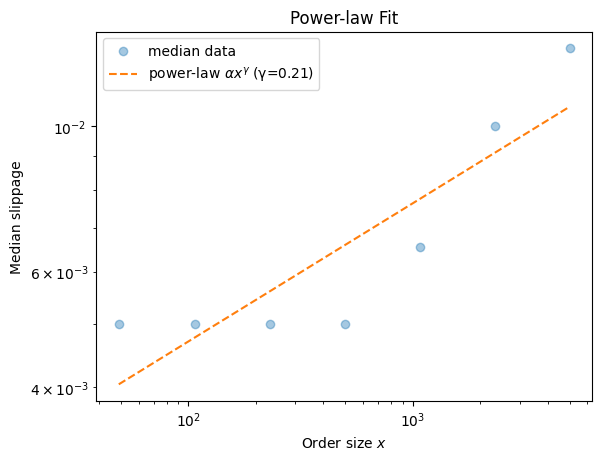

In [119]:
x, y = sub['size'].values, sub['median_slip'].values
alpha, gamma = powerlaw_df.loc[ticker, ['α (alpha)', 'γ (gamma)']]
xs = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)

plt.figure()
plt.scatter(x, y, alpha=0.4, label='median data')
plt.plot(xs, alpha*xs**gamma, 'C1--', label=f'power-law $αx^{{γ}}$ (γ={γ:.2f})')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Order size $x$'); plt.ylabel('Median slippage')
plt.title(f'Power-law Fit')
plt.legend(); 
plt.show()

### Almgren-Chriss Model

In [113]:
ac_results = []
for ticker, sub in median_slippage.groupby('ticker'):
    x = sub['size'].values.reshape(-1,1)
    y = sub['median_slip'].values

    X_ac = np.hstack([x, x**2])

    model = LinearRegression(fit_intercept=False).fit(X_ac, y)
    eta    = model.coef_[0]
    gamma    = 2 * model.coef_[1]  
    ac_results.append({'ticker':ticker,'eta':eta,'Gamma':gamma}
                     
                     )
ac_df = pd.DataFrame(ac_results).set_index('ticker')
print(ac_df)

             eta         Gamma
ticker                        
CRWV    0.000125 -3.778388e-08
FROG    0.000137 -4.857715e-08
SOUN    0.000007 -1.839099e-09


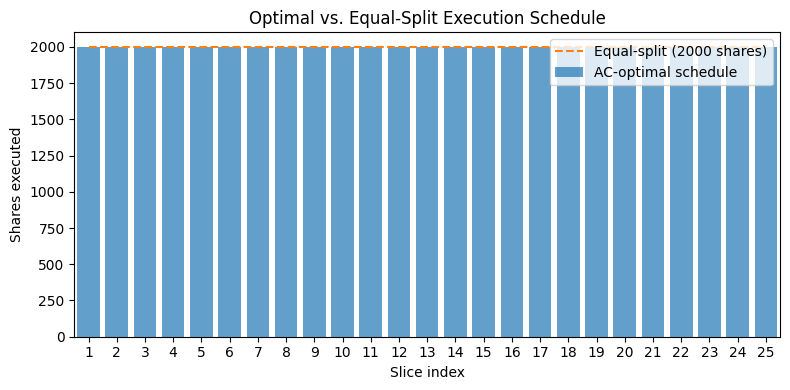

In [120]:
# result from running src/optimi
schedule = np.array([2000.] * 25)

# total and number of slices
S = schedule.sum()
N = schedule.size


equal_split = S / N


fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(1, N + 1)

ax.bar(x, schedule, color='C0', alpha=0.7, label='AC‐optimal schedule')
ax.hlines(equal_split, xmin=1, xmax=N, colors='C1', linestyles='--', label=f'Equal‐split ({equal_split:.0f} shares)')

ax.set_xlabel('Slice index')
ax.set_ylabel('Shares executed')
ax.set_title('Optimal vs. Equal‐Split Execution Schedule')
ax.set_xticks(x)
ax.set_xlim(0.5, N + 0.5)
ax.legend()

plt.tight_layout()
plt.show()